## Vehicle Detection

In this project, my goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4). 

Steps of the pipeline are:
* Prepare the training image and test image
* Extract features from image
* Prepare the data
* Train the model
* Search for cars in the the image
* Deal with duplication and false detection
* Draw rectangle on the image

### First I'll write a funtion to extract the feature of our test image. (This function is from the lecture practise)

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features = [] 
        hog_image = img 
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

### Test the get_hog_features and get visualization of hog image

feature size:  509436


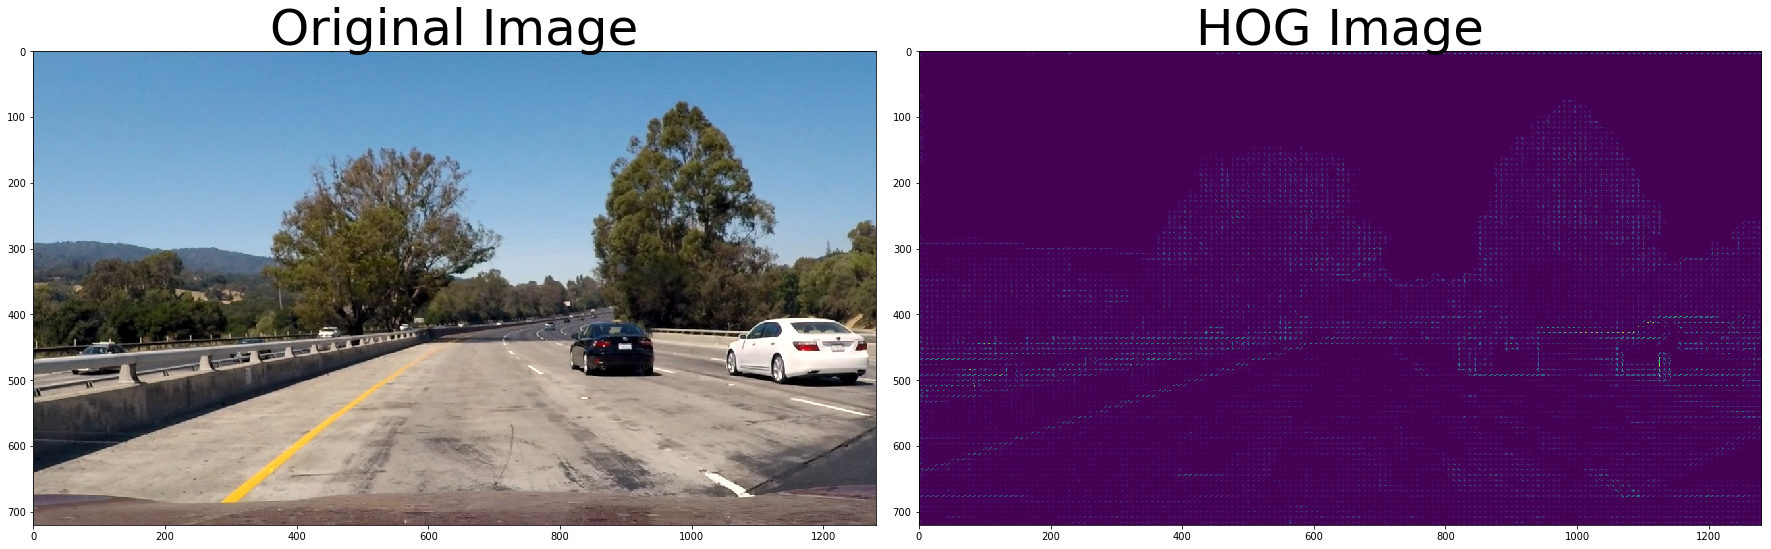

In [11]:
# parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# import image
img = mpimg.imread('./test_images/test1.jpg')
# grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, feature_vec=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hog_image)
ax2.set_title('HOG Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print('feature size: ', len(hog_features))

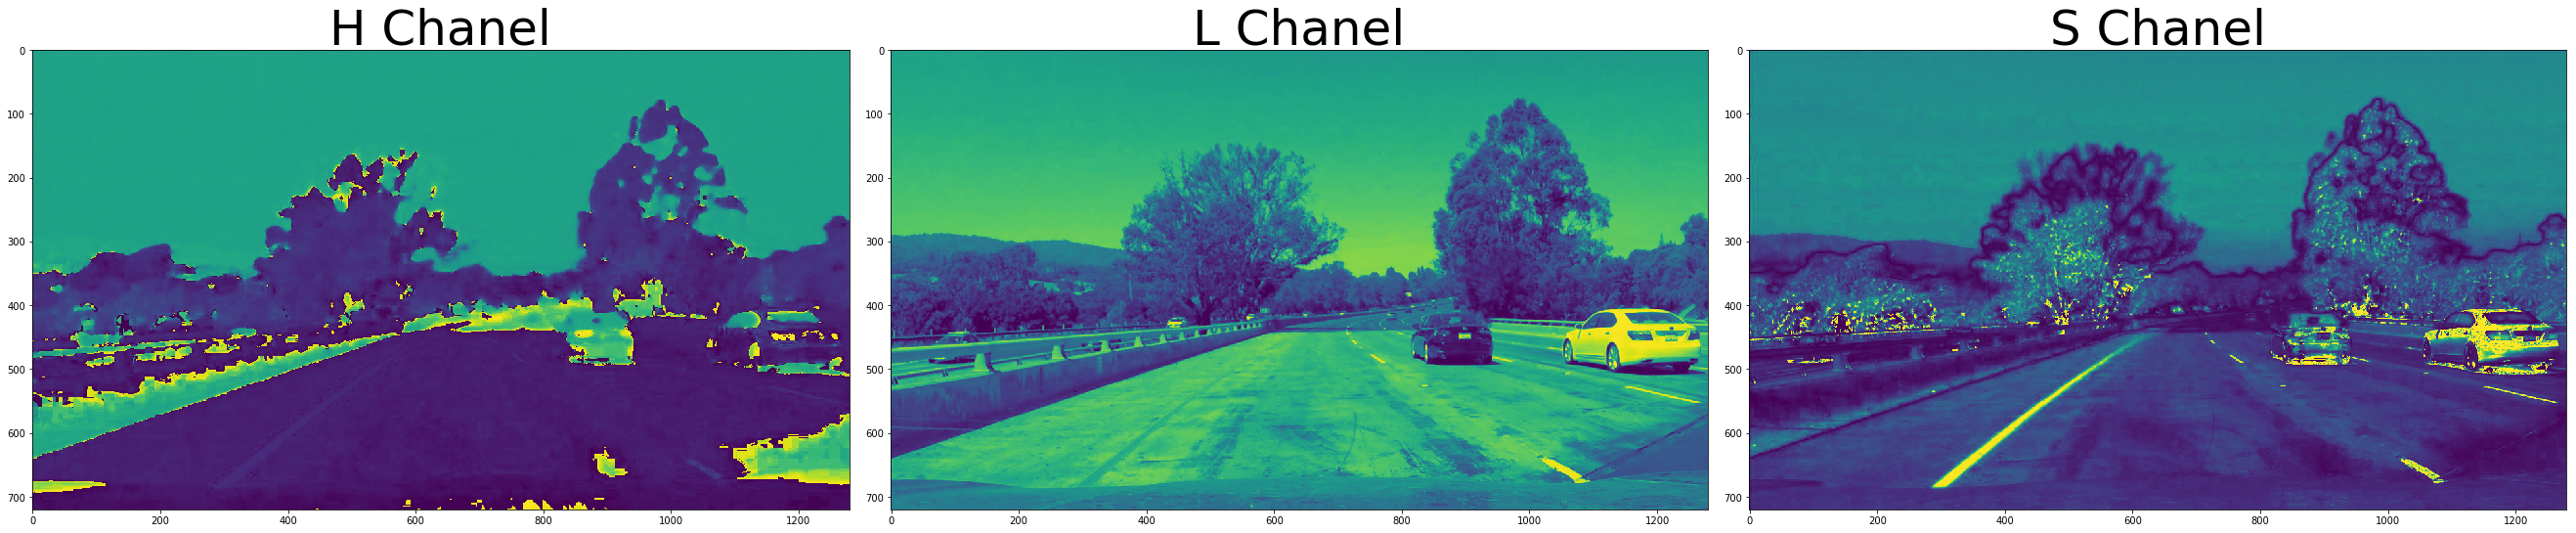

In [13]:
### Experiment with color space
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 9))
f.tight_layout()
ax1.imshow(H)
ax1.set_title('H Chanel', fontsize=50)
ax2.imshow(L)
ax2.set_title('L Chanel', fontsize=50)
ax3.imshow(S)
ax3.set_title('S Chanel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

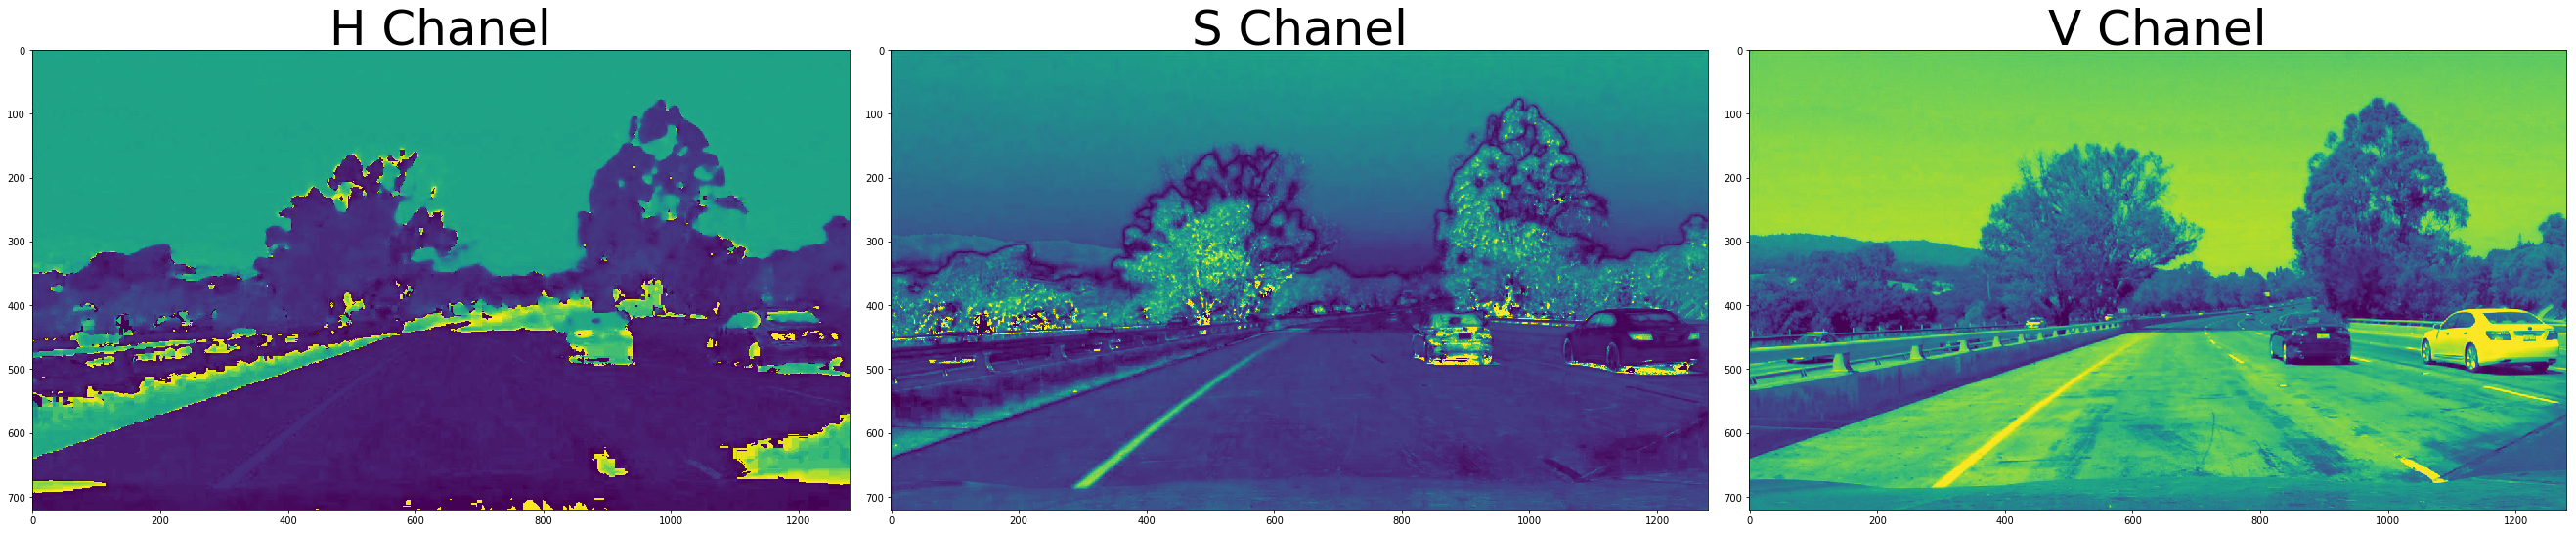

In [31]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
H = hls[:,:,0]
S = hls[:,:,1]
V = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 9))
f.tight_layout()
ax1.imshow(H)
ax1.set_title('H Chanel', fontsize=50)
ax2.imshow(S)
ax2.set_title('S Chanel', fontsize=50)
ax3.imshow(V)
ax3.set_title('V Chanel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

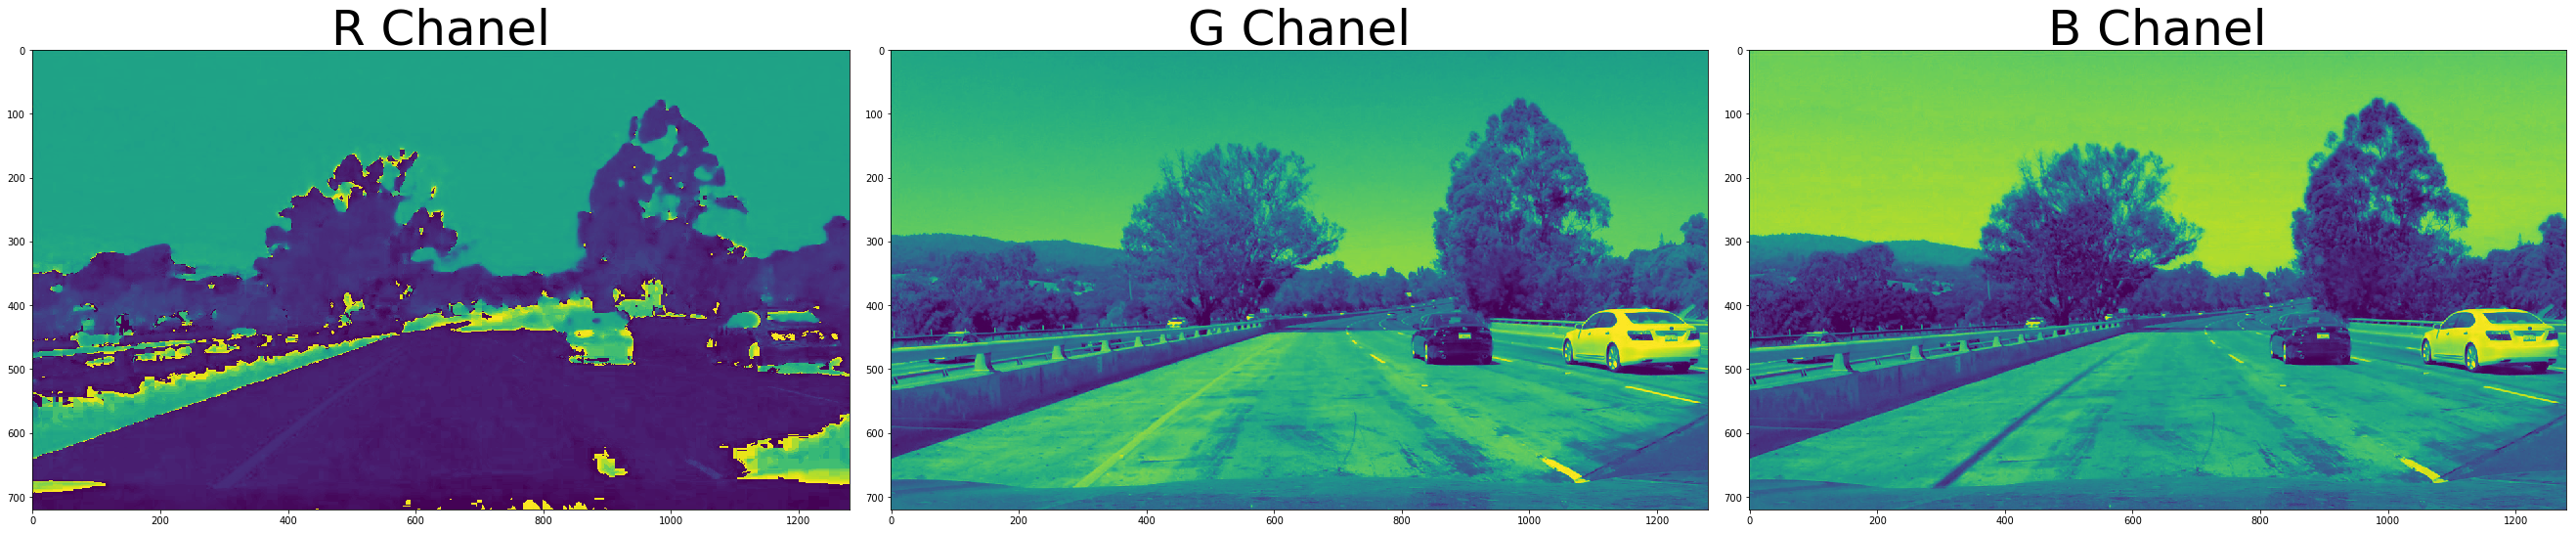

In [33]:
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 9))
f.tight_layout()
ax1.imshow(H)
ax1.set_title('R Chanel', fontsize=50)
ax2.imshow(G)
ax2.set_title('G Chanel', fontsize=50)
ax3.imshow(B)
ax3.set_title('B Chanel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Define a function to extract features from a list of images

In [44]:
def get_color_features(image, cspace='RGB',
                        hist_bins=32, hist_range=(0, 256)):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)      
  
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(feature_image[:,:,0], bins=hist_bins, range=hist_range)
    channel2_hist = np.histogram(feature_image[:,:,1], bins=hist_bins, range=hist_range)
    channel3_hist = np.histogram(feature_image[:,:,2], bins=hist_bins, range=hist_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return list of feature vectors
    return hist_features


In [45]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(img, cspace='RGB',
                        hist_bins=32, hist_range=(0, 256)):
    # Apply get_hog_features() 
    hog_features = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=False, feature_vec=True)
    # Apply get_color_features()
    color_features = get_color_features(img, cspace=cspace, hist_bins=hist_bins, hist_range=hist_range)
    # Append the new feature vector to the features list
    features = np.concatenate((hog_features, color_features))
    # Return list of feature vectors
    return features

In [46]:
features = extract_features(img)

[  1.12239093e-02   3.45514121e-02   3.45514121e-02 ...,   1.81400000e+03
   2.33700000e+03   2.49100000e+03]
